# keras와 Pytorch비교
* make date : 2024-03-27
* 신재호

# keras cifar10분류

In [ ]:
from keras.datasets import cifar10
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.metrics import confusion_matrix

(X_train, y_train), (X_val, y_val) = cifar10.load_data()
label_name = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

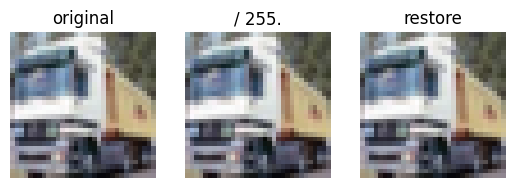

In [ ]:
plt.subplot(1,3,1)
plt.imshow(X_train[1])
plt.axis('off')
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(X_train[1]/255.)
plt.axis('off')
plt.title('/ 255.')

plt.subplot(1,3,3)
a = X_train[1]/255. * 255.
plt.imshow(a.astype(int))
plt.axis('off')
plt.title('restore')

plt.show()

In [ ]:
X_train = X_train.reshape(-1,32,32,3)/255.
X_val = X_val.reshape(-1,32,32,3)/255.

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

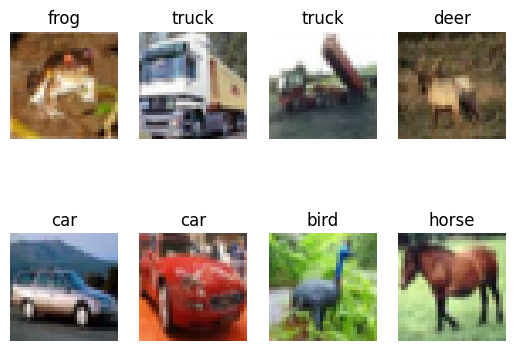

In [ ]:
for i in range(8):
  plt.subplot(2,4,i+1)
  restor_X = X_train[i] * 255.
  plt.imshow(restor_X.astype(int))
  plt.title(f'{label_name[y_train[i].argmax(0)]}')
  plt.axis('off')

In [ ]:
class DataLoader(Sequence):
  def __init__(self, batch_size, X, y):
    self.batch_size = batch_size
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    start, end = idx * self.batch_size, (idx + 1) * self.batch_size
    return self.X[start:end], self.y[start:end]

  def __len__(self):
    return math.ceil(len(self.y)/self.batch_size)

def Simple_CNN():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation="relu",input_shape=(32,32,3)))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3),activation="relu"))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation = 'relu'))
  model.add(Dense(10, activation = 'softmax'))
  return model

In [ ]:
train_loader = DataLoader(32, X_train, y_train)
val_loader = DataLoader(32, X_val, y_val)


model = Simple_CNN()
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['acc'])
model_checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, verbose=1,
                                   filepath = '/content/keras_CNN.keras')
history = model.fit(train_loader, validation_data = val_loader, epochs = 10, callbacks = [model_checkpoint])

Epoch 1/10
1557/1563 [============================>.] - ETA: 0s - loss: 1.4507 - acc: 0.5165
Epoch 1: val_loss improved from inf to 1.14923, saving model to /content/keras_CNN.keras
1563/1563 [==============================] - 12s 7ms/step - loss: 1.4491 - acc: 0.5169 - val_loss: 1.1492 - val_acc: 0.5978
Epoch 2/10
1558/1563 [============================>.] - ETA: 0s - loss: 0.7898 - acc: 0.7236
Epoch 2: val_loss improved from 1.14923 to 1.03595, saving model to /content/keras_CNN.keras
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7893 - acc: 0.7238 - val_loss: 1.0360 - val_acc: 0.6425
Epoch 3/10
1559/1563 [============================>.] - ETA: 0s - loss: 0.4356 - acc: 0.8544
Epoch 3: val_loss did not improve from 1.03595
1563/1563 [==============================] - 14s 9ms/step - loss: 0.4357 - acc: 0.8544 - val_loss: 1.1339 - val_acc: 0.6442
Epoch 4/10
1563/1563 [==============================] - ETA: 0s - loss: 0.1732 - acc: 0.9528
Epoch 4: val_loss did not i

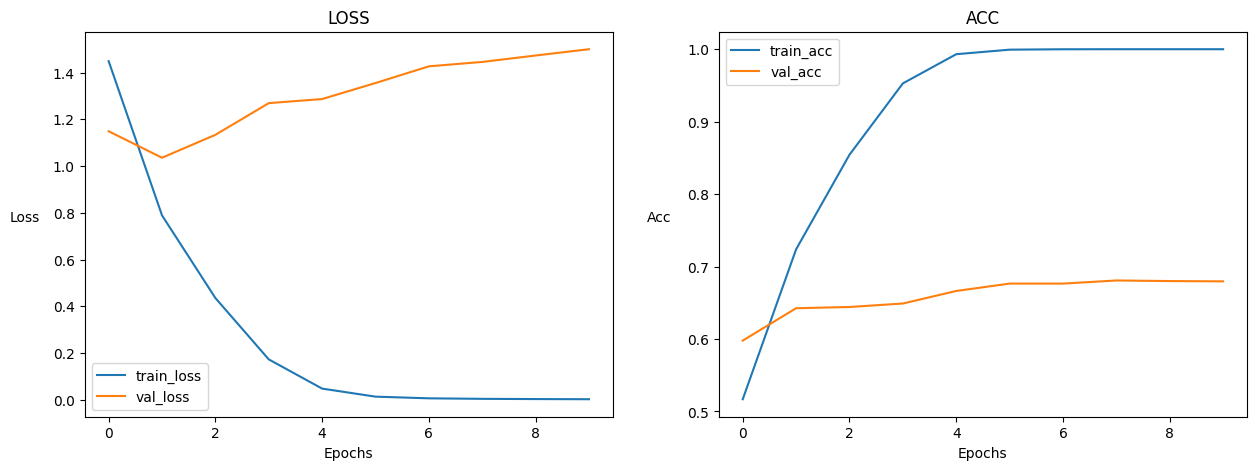

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label = 'train_acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.title('ACC')
plt.xlabel('Epochs')
plt.ylabel('Acc', rotation = 360, labelpad = 20)

plt.show()


In [ ]:
def batch_extractor(batch_no, model, loader):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x
    labels = y.argmax(1)
    if i == batch_no - 1:
      break
  preds = model.predict(imgs).argmax(1)
  imgs = imgs * 255.
  imgs = imgs.astype(int)
  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

1/1 [==============================] - 0s 17ms/step


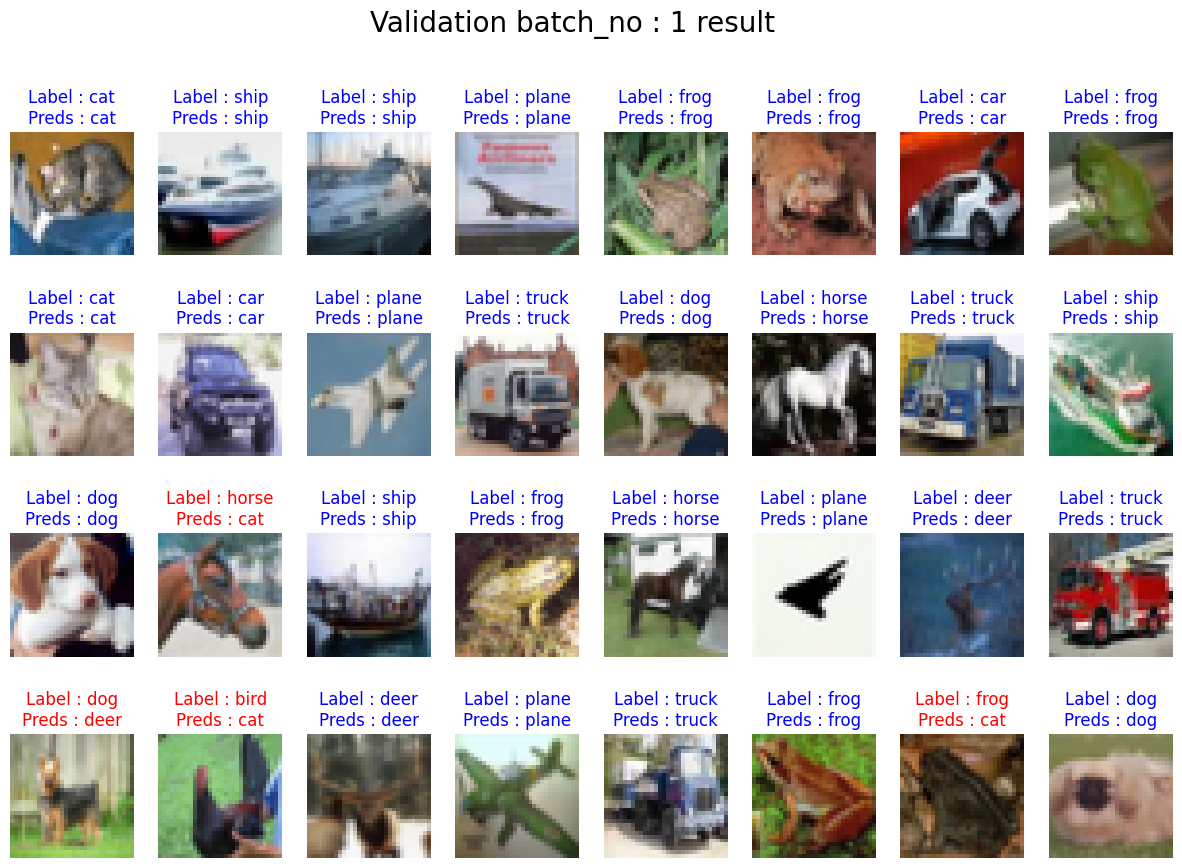

In [ ]:
batch_no = 1
extract_dict = batch_extractor(batch_no = batch_no, model = model, loader = val_loader)

plt.figure(figsize = (15,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(extract_dict['imgs'][i])
  plt.axis('off')
  if extract_dict['preds'][i] == extract_dict['labels'][i]:
    color = "blue"
  else:
    color = "red"
  plt.title(f'Label : {label_name[extract_dict["labels"][i]]}\nPreds : {label_name[extract_dict["preds"][i]]}', color = color)
plt.suptitle(f"Validation batch_no : {batch_no} result", fontsize = 20)
plt.show()

In [ ]:
preds = model.predict(X_val).argmax(1)
labels = y_val.argmax(1)

conf_array = np.zeros(10)
tmp_df = pd.DataFrame(conf_array)
conf_df = pd.DataFrame()
for i in range(10):
  conf_df = pd.concat([conf_df, tmp_df.T], axis = 0)
conf_df.index = [i for i in range(10)]

for i in range(len(preds)):
  conf_df.loc[labels[i], preds[i]] += 1
conf_df = conf_df.astype(int)
conf_df

313/313 [==============================] - 1s 2ms/step


0    1    2    3    4    5    6    7    8    9
0  728   26   51   27   22   11   10   13   68   44
1   35  784    8   16    2    4   10    4   32  105
2   76   10  536   77  101   78   64   35   13   10
3   28   17   75  493   49  191   72   40   16   19
4   25    3   71   63  650   25   57   89   11    6
5   14    8   63  191   49  560   28   60   16   11
6   10    9   59   67   41   23  764   10   10    7
7   15    6   36   45   66   78    8  720    1   25
8   76   44   12   16    5    5    3    3  803   33
9   45   89   10   26    5    8    5   24   30  758

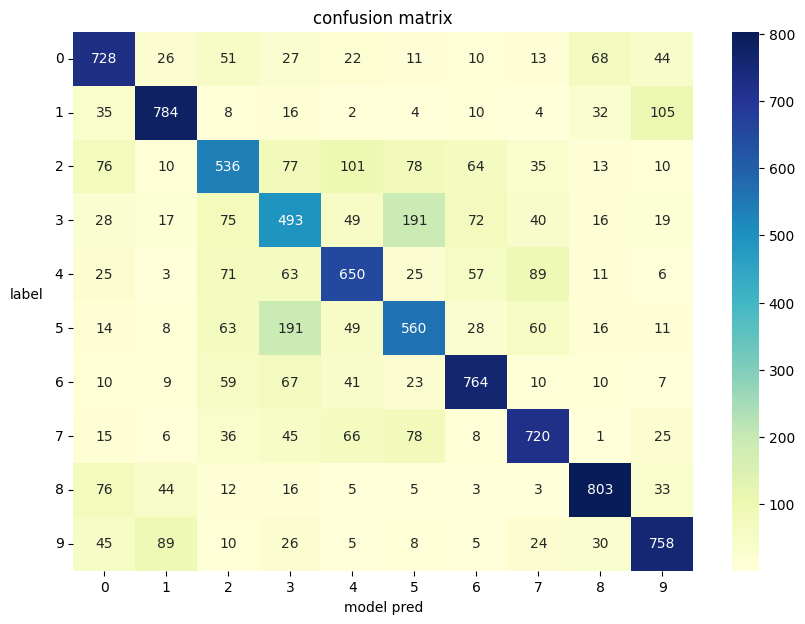

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot = True, fmt = 'd', cmap='YlGnBu')
plt.yticks(rotation = 360)
plt.xlabel('model pred')
plt.ylabel('label', rotation = 360, labelpad = 20)
plt.title('confusion matrix')
plt.show()

In [ ]:
wrong_img = []
wrong_label = []
wrong_pred = []

for i in range(len(preds)):
  if preds[i] != labels[i]:
    restore_X = X_val[i] * 255.

    wrong_img.append(restore_X.astype(int))
    wrong_label.append(labels[i])
    wrong_pred.append(preds[i])

wrong_img = np.array(wrong_img)
wrong_label = np.array(wrong_label)
wrong_pred = np.array(wrong_pred)

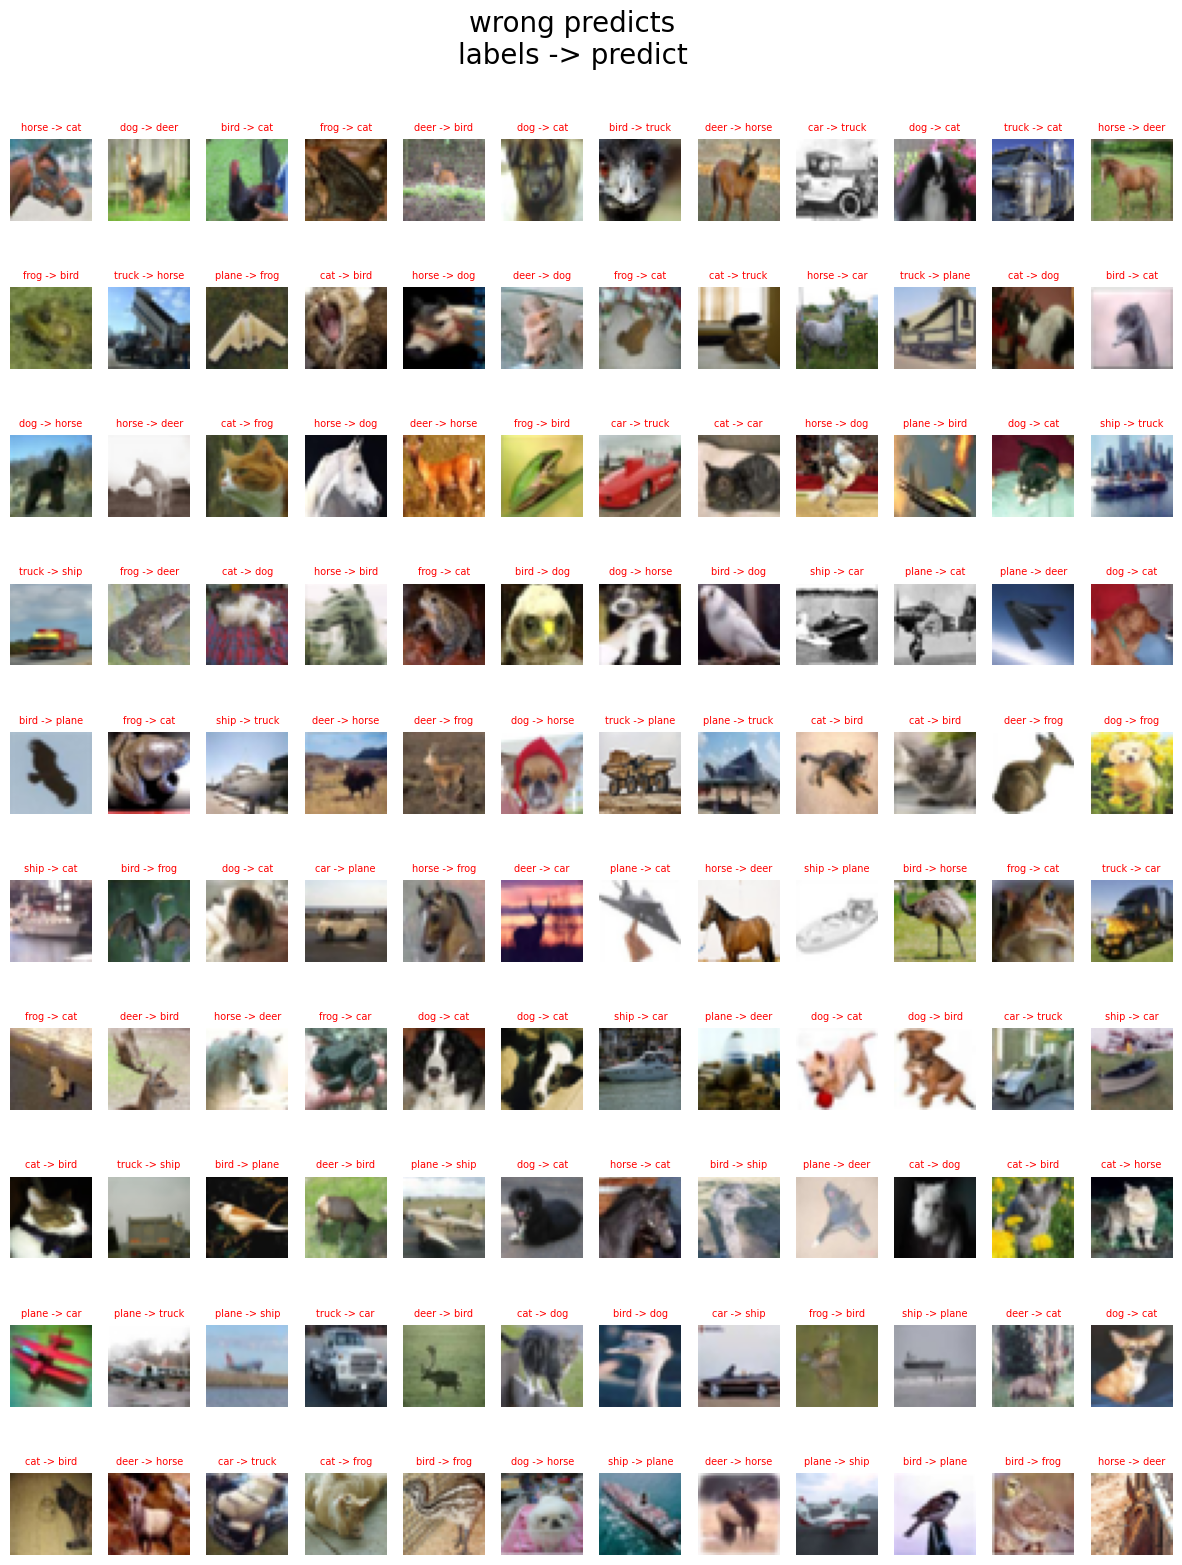

In [ ]:
plt.figure(figsize = (15,18))
for i in range(len(wrong_img)):
  plt.subplot(10, 12, i + 1)
  plt.imshow(wrong_img[i])
  plt.axis('off')
  plt.title(f'{label_name[wrong_label[i]]} -> {label_name[wrong_pred[i]]}', color = "red", fontsize = 7)
  if i > 118:
    break
plt.suptitle("wrong predicts\nlabels -> predict", fontsize = 20)
plt.subplots_adjust(top=0.92)
plt.show()

# Pytorch MNIST 분류

In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
)

train_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
val_dataset = datasets.CIFAR10(root = './data', train = False, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

Files already downloaded and verified


torch.Size([3, 32, 32])


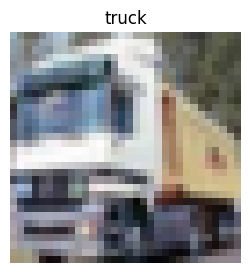

In [ ]:
plt.figure(figsize = (3,3))
for x, y in train_loader:
  imgs = x[1]
  print(imgs.shape)
  imgs = imgs / 2 + 0.5
  imgs = imgs.numpy()
  plt.imshow(np.transpose(imgs, (1,2,0)))
  plt.axis('off')
  plt.title(f'{label_name[y[1]]}')
  break

In [ ]:
class Simple_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.dense1 = nn.Sequential(
        nn.Linear(in_features = 64 * 28 * 28, out_features = 128),
        nn.ReLU()
    )
    # 파이토치의 nn.CrossEntropy는 softmax가 합쳐저 있으므로 따로 softmax층을 선언할 필요없음!!
    self.dense2 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    # flatten
    out = out.reshape(out.size(0), -1)
    out = self.dense1(out)
    out = self.dense2(out)
    return out

In [ ]:
def train(model, loader, criterion, optimizer):
  '''
  학습을 위한 함수
  '''
  model.train()
  train_loss = 0.
  train_acc = 0.

  for X, y in loader:

    #X = X.view(32,1,28,28)
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # loss
    train_loss += loss.item()

    # acc
    pred = y_hat.max(1, keepdim = True)[1]
    train_acc += pred.eq(y.data.view_as(pred)).sum().item()

  train_loss  = train_loss / len(loader)
  train_acc = train_acc / len(loader.dataset)

  return train_loss, train_acc

def val(model, loader, criterion):
  '''
  검증을 위한 함수
  '''
  model.eval()
  val_loss = 0.
  val_acc = 0.

  with torch.no_grad():
    for X, y in loader:
      #X = X.view(32,1,28,28)
      X = X.to(device)
      y = y.to(device)

      y_hat = model(X)
      loss = criterion(y_hat, y)
      val_loss += loss.item()

      # acc
      pred = y_hat.max(1, keepdim = True)[1]
      val_acc += pred.eq(y.data.view_as(pred)).sum().item()

  val_loss  = val_loss / len(loader)
  val_acc = val_acc / len(loader.dataset)

  return val_loss, val_acc

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

model = Simple_CNN().to(device)

epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
st_loss = 1000

for epoch in range(epochs):
  print(f'########### epoch : {epoch + 1} ###########')
  train_loss, train_acc = train(model, train_loader, criterion, optimizer)
  val_loss, val_acc = val(model, val_loader, criterion)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
  if val_loss < st_loss:
    print(f'* train_loss = {train_loss}, train_acc = {train_acc}, val_acc = {val_acc}')
    print(f'* val_loss가 향상되었습니다. {st_loss} ==> {val_loss}')
    st_loss = val_loss
    torch.save(model.state_dict(), '/content/pytorch_CNN.pt')
  else:
    print(f'* train_loss = {train_loss}, train_acc = {train_acc}, val_acc = {val_acc}')
    print(f'* val_loss가 향상되지 않았습니다, val_loss = {val_loss}')

########### epoch : 1 ###########
* train_loss = 1.2350288841696921, train_acc = 0.55988, val_acc = 0.6384
* val_loss가 향상되었습니다. 1000 ==> 1.0237679716486197
########### epoch : 2 ###########
* train_loss = 0.711577893743976, train_acc = 0.75336, val_acc = 0.6596
* val_loss가 향상되었습니다. 1.0237679716486197 ==> 1.0150052263186529
########### epoch : 3 ###########
* train_loss = 0.3445352298874174, train_acc = 0.89394, val_acc = 0.6698
* val_loss가 향상되지 않았습니다, val_loss = 1.1237185121728823
########### epoch : 4 ###########
* train_loss = 0.11121695822524563, train_acc = 0.97442, val_acc = 0.6797
* val_loss가 향상되지 않았습니다, val_loss = 1.216618187725544
########### epoch : 5 ###########
* train_loss = 0.03321855898890477, train_acc = 0.99594, val_acc = 0.6914
* val_loss가 향상되지 않았습니다, val_loss = 1.2655830861857305
########### epoch : 6 ###########
* train_loss = 0.012024155347941923, train_acc = 0.99936, val_acc = 0.6968
* val_loss가 향상되지 않았습니다, val_loss = 1.3122348146369824
########### epoch : 7 ######

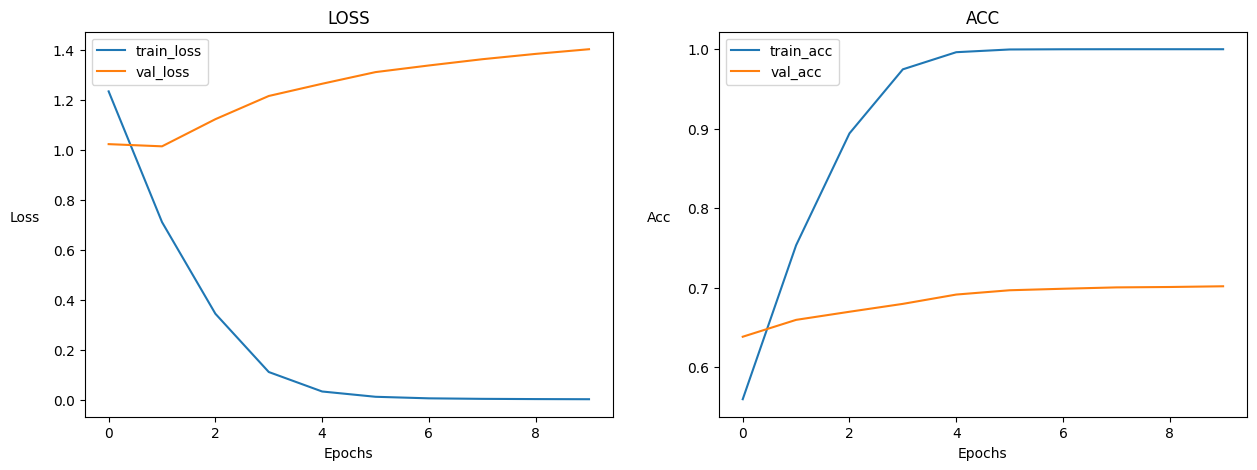

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)

plt.subplot(1,2,2)
plt.plot(train_acc_list, label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.legend()
plt.title('ACC')
plt.xlabel('Epochs')
plt.ylabel('Acc', rotation = 360, labelpad = 20)

plt.show()

In [ ]:
def batch_extractor(batch_no, loader, model):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x.to(device)
    labels = y.numpy()
    if i == batch_no - 1:
      break
  model.eval()
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)

  imgs = imgs.detach().to('cpu').numpy() / 2 + 0.5
  imgs = np.transpose(imgs, (0,2,3,1))

  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

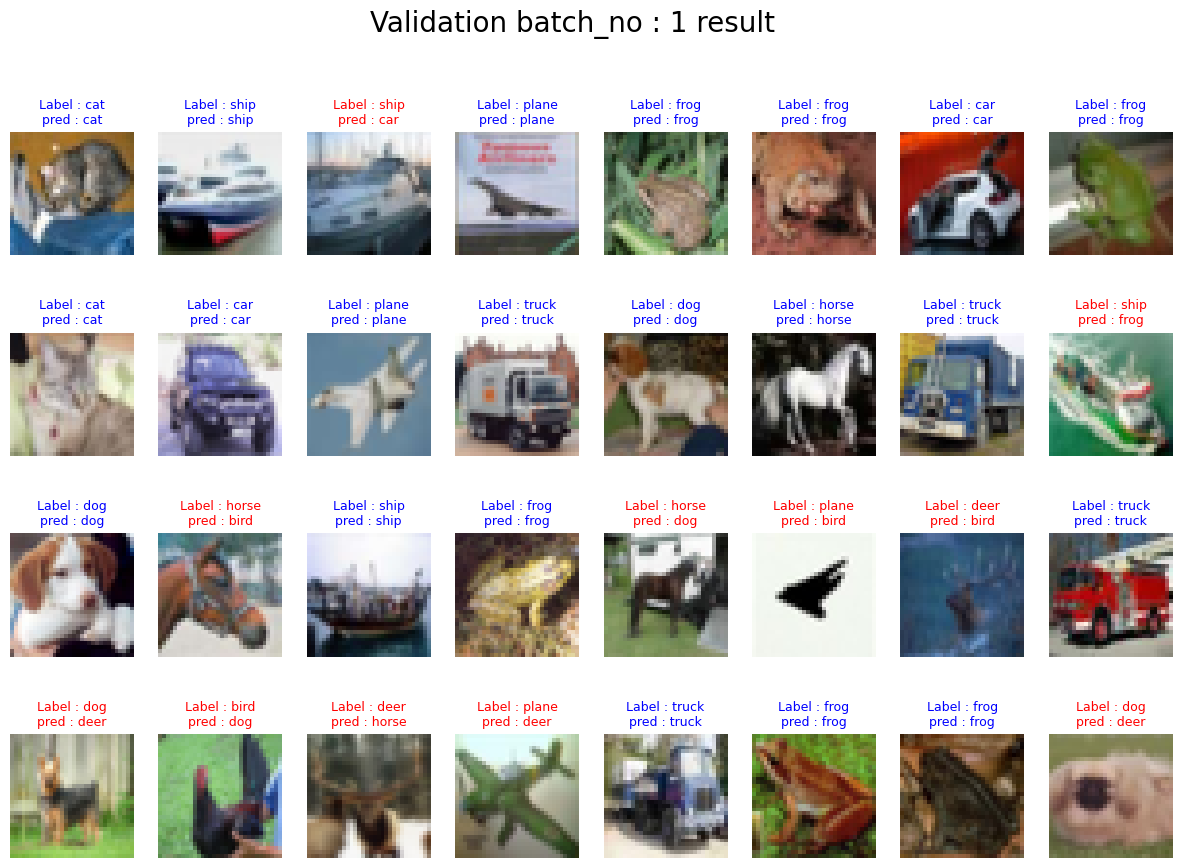

In [ ]:
batch_no = 1
extract_dict = batch_extractor(batch_no = batch_no, loader = val_loader, model = model)
plt.figure(figsize = (15,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(extract_dict['imgs'][i])
  if extract_dict['preds'][i] == extract_dict['labels'][i]:
    color = "blue"
  else:
    color = "red"
  plt.title(f'Label : {label_name[extract_dict["labels"][i]]}\npred : {label_name[extract_dict["preds"][i]]}', color = color, fontsize = 9)
  plt.axis('off')
plt.suptitle(f'Validation batch_no : {batch_no} result', fontsize = 20)
plt.show()

In [ ]:
labels = []
preds = []

model.eval()
with torch.no_grad():
  for img, label in val_loader:
    labels.append(label.numpy())

    img = img.to(device)
    pred = model(img).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
    preds.append(pred)

preds = np.array(preds).reshape(-1)
labels = np.array(labels).reshape(-1)

In [ ]:
tmp_df = pd.DataFrame(np.zeros(10).T)
conf_df = pd.DataFrame()
for i in range(10):
  conf_df = pd.concat([conf_df, tmp_df], axis = 1)
conf_df.index = [i for i in range(10)]
conf_df.columns = [i for i in range(10)]

for i in range(len(labels)):
  conf_df.loc[labels[i], preds[i]] += 1
conf_df = conf_df.astype(int)
conf_df

0    1    2    3    4    5    6    7    8    9
0  751   20   46   25   17    7   12    7   81   32
1   26  801    5   15    2    5   12    4   32   97
2   66    5  563   76  102   65   59   35   12   16
3   28   11   71  502   67  194   67   25   16   16
4   27    6   56   64  659   31   67   76    9    5
5   15    6   49  165   55  621   22   57    2    5
6    8    8   33   57   45   23  804    8    9    5
7   21   10   37   42   58   66    6  737    6   14
8   64   50   14   16    5    7    6    4  804   27
9   32   81   13   18    8   10    8   16   38  776

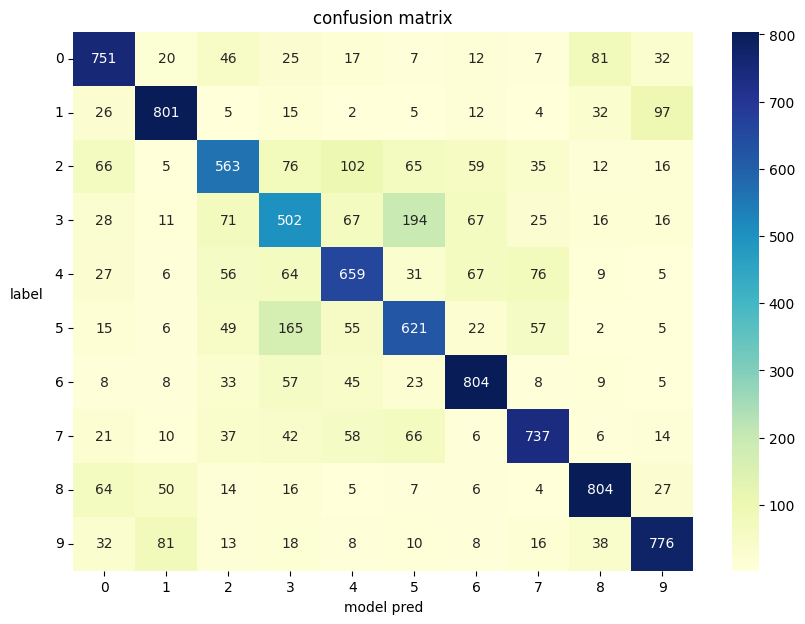

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot = True, fmt = 'd', cmap='YlGnBu')
plt.yticks(rotation = 360)
plt.xlabel('model pred')
plt.ylabel('label', rotation = 360, labelpad = 20)
plt.title('confusion matrix')
plt.show()

In [ ]:
wrong_img = []
wrong_label = []
wrong_pred = []

for data in val_loader:
  x, y = data
  imgs = x.to(device)
  labels = y.numpy()
  model.eval()
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
  imgs = imgs.detach().to('cpu').numpy() / 2 + 0.5
  imgs = np.transpose(imgs, (0,2,3,1))

  for i in range(len(preds)):
    if preds[i] != labels[i]:
      wrong_img.append(imgs[i])
      wrong_label.append(labels[i])
      wrong_pred.append(preds[i])
wrong_img = np.array(wrong_img)
wrong_label = np.array(wrong_label)
wrong_pred = np.array(wrong_pred)

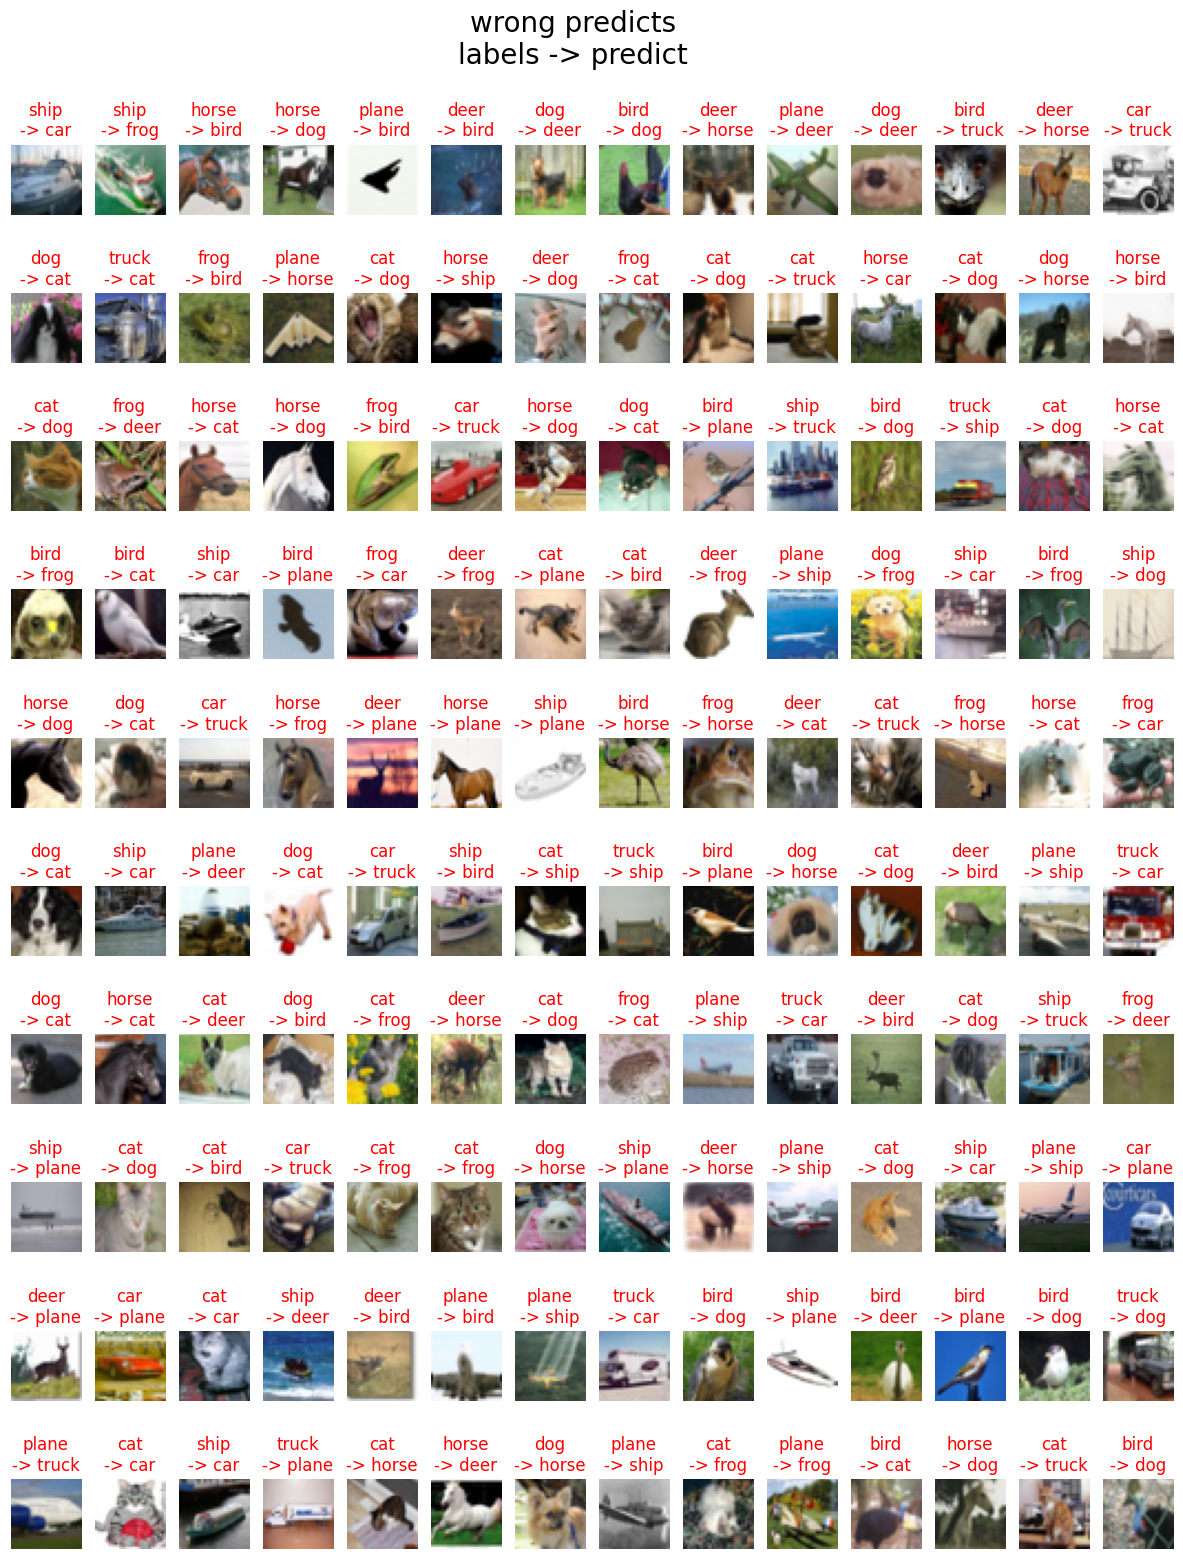

In [ ]:
plt.figure(figsize = (15,18))
for i in range(len(wrong_img)):
  plt.subplot(10, 14, i + 1)
  plt.imshow(wrong_img[i], cmap = plt.cm.binary)
  plt.axis('off')
  plt.title(f'{label_name[wrong_label[i]]}\n-> {label_name[wrong_pred[i]]}', color = "red")
  if i > 138:
    break
plt.suptitle("wrong predicts\nlabels -> predict", fontsize = 20)
plt.subplots_adjust(top=0.92)
plt.show()

# 객체 지향

In [ ]:
class DataLoader(Sequence):
  def __init__(self, batch_size, X, y):
    self.batch_size = batch_size
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    start, end = idx * self.batch_size, (idx + 1) * self.batch_size
    return self.X[start:end], self.y[start:end]

  def __len__(self):
    return math.ceil(len(self.y)/self.batch_size)

In [ ]:
class Person():
  def __init__(self, name, age):
    self.name = name
    self.age = age
    print("Person __init__ 수행")

  def work(self,hour):
    print(f"{self.name}가 {hour}시간 일을 합니다.")

class Student(Person):
  def __init__(self, name, age):
    super().__init__(name, age)
    self.name = name
    self.age = age
    print("Student __init__ 수행")

  def work(self, hour):
    super().work(hour)
    print(f"{self.name}가 {hour}시간 공부를 합니다.")

In [ ]:
p1 = Person(name = "신재호", age = 27)

Person __init__ 수행


In [ ]:
s1 = Student(name = "신재호", age = 27)

Person __init__ 수행
Student __init__ 수행


In [ ]:
class Simple_layer(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(in_features = 3, out_features = 1)

  def forward(self,x):
    return self.linear(x)

* \_\_init\_\_
* \_\_len\_\_
* \_\_getitem\_\_

In [ ]:
class List_Reader():
  def __init__(self, l1):
    self.l1 = l1

  def length_reader(self):
    return len(self.l1)

  def __len__(self):
    return len(self.l1)

  def indexer(self, idx):
    return self.l1[idx]

  def __getitem__(self,idx):
    return self.l1[idx]

In [ ]:
lr = List_Reader([1,2,3,4,5,6,7,8,9,10])

In [ ]:
lr.indexer(4)

5

* \_\_all\_\_

In [ ]:
from test import *

In [ ]:
h1 = human(name="신재호", age =27)

Person __init__ 수행


In [ ]:
a1 = animal(name = "푸", age = 3)